# Determine Stage 8 End of Stage Logic

**Goal**: determine what/how animals in V2 of the Fixation Grower protocol will advance from stage 8 into the probe stages

**Context**: stage 8 is when the violation penalty turns on. I showed in the `assess_dms_gnp_data` notebook that this had a big effect on violation rates. when training DMS2 animals, I used violation rate < 20% as a metric for advancement. This is too circular given I want to use violation rate as a metric for experiment comparison. So, I want to find other metrics that can instead be used to move an animal out of this stage. 

**Ideas**:

* find a way to normalize violation rate 
    * day (day -1) before stage 8 is 0, best violation rate is 1 
* look at delta violation rates day to day as well as to best violation rate
* look at days to best violation rate


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from stage_8_EOS_logic import *

sns.set_context("talk")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Wrangling

1. Load in Data
2. Make relative to starting stage 8 (include final days in stage 7)
3. Git rid of animals with abnormal data

In [6]:
save_name = "processed_df.csv"
save_path = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/analyses/fixation_experiment"

df = pd.read_csv(save_path + save_name)
df["date_time_date"] = pd.to_datetime(df["date_time_date"])
df = df.query("stage >=5 and stage <= 8 and session < 50").copy()

animals_to_drop = ["C214"]  # never got fixation due to concurrent spoke
df = df.query("animal_id not in @animals_to_drop").copy()

In [7]:
df.head()

,trial,animal_id,date,sess_id,hits,violations,stage,sa,sb,stimuli_on,...,sound_pair,give_type_imp,give_frac,n_settling_ins,avg_settling_in,cpoke_dur,date_time_date,session,cumulative_trial,fixation_dur
0,97,R010,2023-09-11,928485,1.0,0.0,5.0,12.0,12.0,False,...,"12.0, 12.0",light,1.0,NaN,NaN,NaN,2023-09-11,1,1,0.01000
1,98,R010,2023-09-11,928485,1.0,0.0,5.0,12.0,12.0,False,...,"12.0, 12.0",water_and_light,1.0,8.0,0.152029,0.4193,2023-09-11,1,2,0.40500
2,99,R010,2023-09-11,928485,1.0,0.0,5.0,3.0,3.0,False,...,"3.0, 3.0",water_and_light,1.0,2.0,0.257900,0.4442,2023-09-11,1,3,0.40500
3,1,R010,2023-09-12,928634,NaN,1.0,5.0,12.0,3.0,False,...,"12.0, 3.0",water_and_light,1.0,8.0,0.124114,0.7556,2023-09-12,2,4,0.43675
4,2,R010,2023-09-12,928634,0.0,0.0,5.0,3.0,12.0,False,...,"3.0, 12.0",water_and_light,1.0,4.0,0.193800,0.7024,2023-09-12,2,5,0.43675


### 1.1 Relative to Stage 8

In [8]:
# Find the minimum date where stage is 8 for each animal
min_date_stage_8 = (
    df.query("stage == 8").groupby("animal_id")["date_time_date"].min().reset_index()
)
min_date_stage_8.rename(columns={"date_time_date": "min_date_stage_8"}, inplace=True)

# Merge the minimum dates back into the original DataFrame
df = df.merge(min_date_stage_8, on="animal_id", how="left")

# Calculate days relative to the minimum date where stage is 8 for each animal
df["days_relative_to_8"] = (df["date_time_date"] - df["min_date_stage_8"]).dt.days

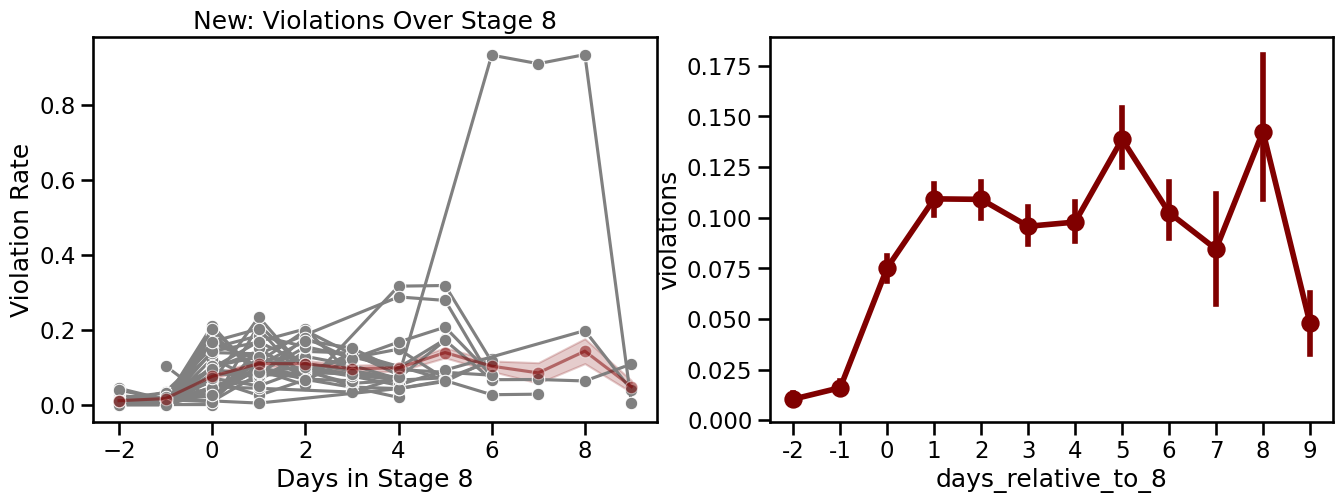

In [9]:
y_var = "violations"
plot_df = df.query("stage < 9 and days_relative_to_8 > -3 and days_relative_to_8 < 10")

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    marker="o",
    palette=sns.color_palette(["gray"], n_colors=plot_df.animal_id.nunique()),
    hue="animal_id",
    ax=ax[0],
    errorbar=None,
    zorder=100,
)

sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    marker="o",
    color="maroon",
    alpha=0.5,
    ax=ax[0],
    zorder=100,
)

sns.pointplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    color="maroon",
    ax=ax[1],
)

_ = ax[0].set(
    xlabel="Days in Stage 8",
    ylabel="Violation Rate",
    title="New: Violations Over Stage 8",
)

ax[0].get_legend().remove()

Note R039 is the outlier with the large peak in violations on days 5-6-7

In [10]:
q = (
    plot_df.groupby(["animal_id", "days_relative_to_8"])["violations"]
    .mean()
    .reset_index()
)

q.max()

animal_id                 R039
days_relative_to_8           9
violations            0.933333
dtype: object

### 1.2 Violations pre stage 8 (proxy)

There are no violations in stage 7 due to the structure of the task. Here, we will use a proxy of multi-cpoke rate which is when nsettling ins > 1 if stage is less than 8.

In [11]:
df["multi_cpoke"] = df["n_settling_ins"] > 1

df["failed_fixation_rate"] = np.where(
    df["days_relative_to_8"] < 0,
    df["multi_cpoke"],
    df["violations"],
)

df["penalty_type"] = np.where(df["days_relative_to_8"] < 0, "none", "time out")

viol_df = (
    df.groupby(["animal_id", "days_relative_to_8"])
    .agg(
        {
            "failed_fixation_rate": "mean",
            "penalty_type": "first",  # Assuming penalty_type is consistent within each group
            "stage": "first",
        }
    )
    .reset_index()
)

In [12]:
viol_df.head()

,animal_id,days_relative_to_8,failed_fixation_rate,penalty_type,stage
0,C215,-18,0.600000,none,5.0
1,C215,-17,0.571429,none,5.0
2,C215,-16,0.181818,none,5.0
3,C215,-8,0.292929,none,5.0
4,C215,-7,0.467105,none,5.0


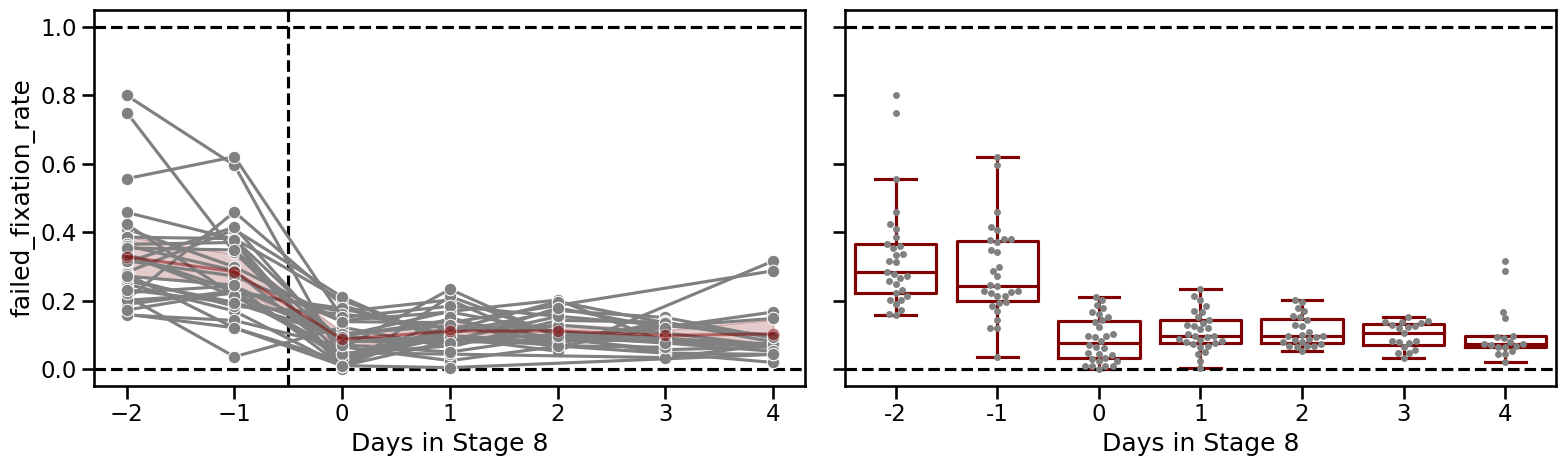

In [13]:
plot_metric_over_stage_8(viol_df, y_var="failed_fixation_rate", set_kwargs={})

## 2. Relative Violation Rates

### 2.1 Violation rate relative to 1 days prior to stage 8 start

Turn this into a flexible function so number of days can change and so that the column can easily be made and appended to a data frame

In [14]:
def calculate_failed_fixation_rate_relative_to_day(df, reference_day):
    def adjust_failed_fixation_rate(group):
        reference_value = group.loc[
            group["days_relative_to_8"] == reference_day, "failed_fixation_rate"
        ]
        if not reference_value.empty:
            reference_value = reference_value.values[0]
            group[f"failed_fixation_rate_relative_to_day_{reference_day}"] = (
                group["failed_fixation_rate"] - reference_value
            )
        else:
            group[f"failed_fixation_rate_relative_to_day_{reference_day}"] = None
        return group

    return (
        df.groupby("animal_id")
        .apply(adjust_failed_fixation_rate, include_groups=True)
        .reset_index(drop=True)
    )

In [15]:
delta_df = calculate_failed_fixation_rate_relative_to_day(viol_df, -1)

delta_df.query("days_relative_to_8 == -1").head()

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_29102/3196474489.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("animal_id")


,animal_id,days_relative_to_8,failed_fixation_rate,penalty_type,stage,failed_fixation_rate_relative_to_day_-1
10,C215,-1,0.459459,none,7.0,0.0
32,C220,-1,0.298507,none,7.0,0.0
61,C221,-1,0.228916,none,7.0,0.0
79,C222,-1,0.595745,none,7.0,0.0
108,C223,-1,0.381188,none,7.0,0.0


/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 63.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


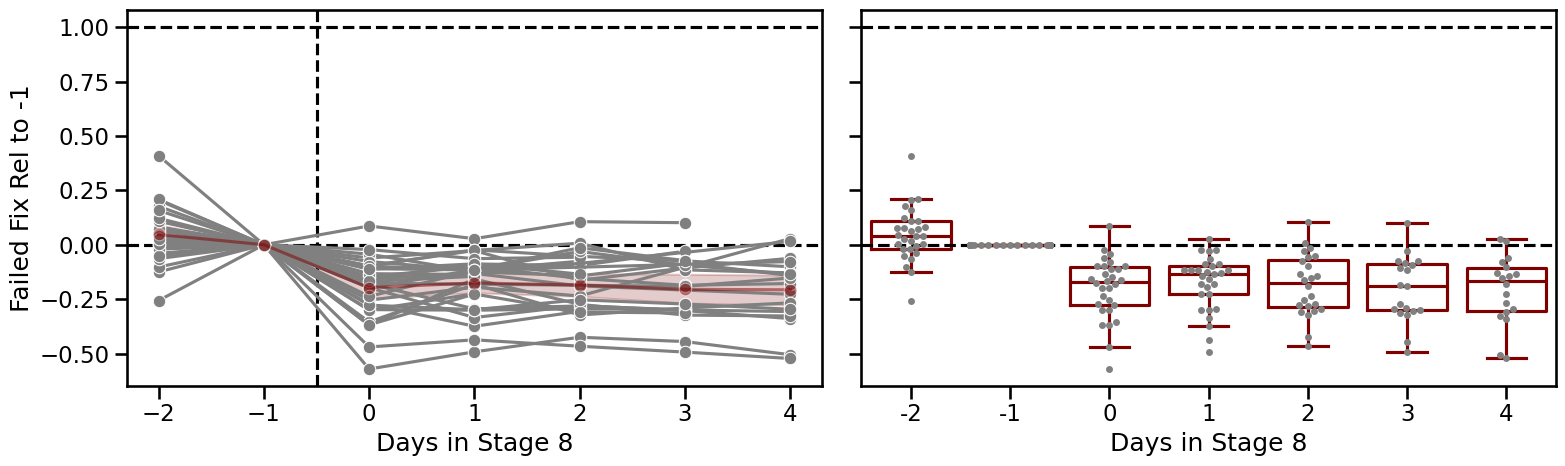

In [16]:
plot_metric_over_stage_8(
    delta_df,
    y_var="failed_fixation_rate_relative_to_day_-1",
    set_kwargs={"ylabel": "Failed Fix Rel to -1"},
)

This plot shows that the fixation rate seems to drop primarily on day 0 (ie the violation penalty immediately has an effect). However, there is quite a lot of variance with this. Again, supporting the idea of a relative metric may be best.

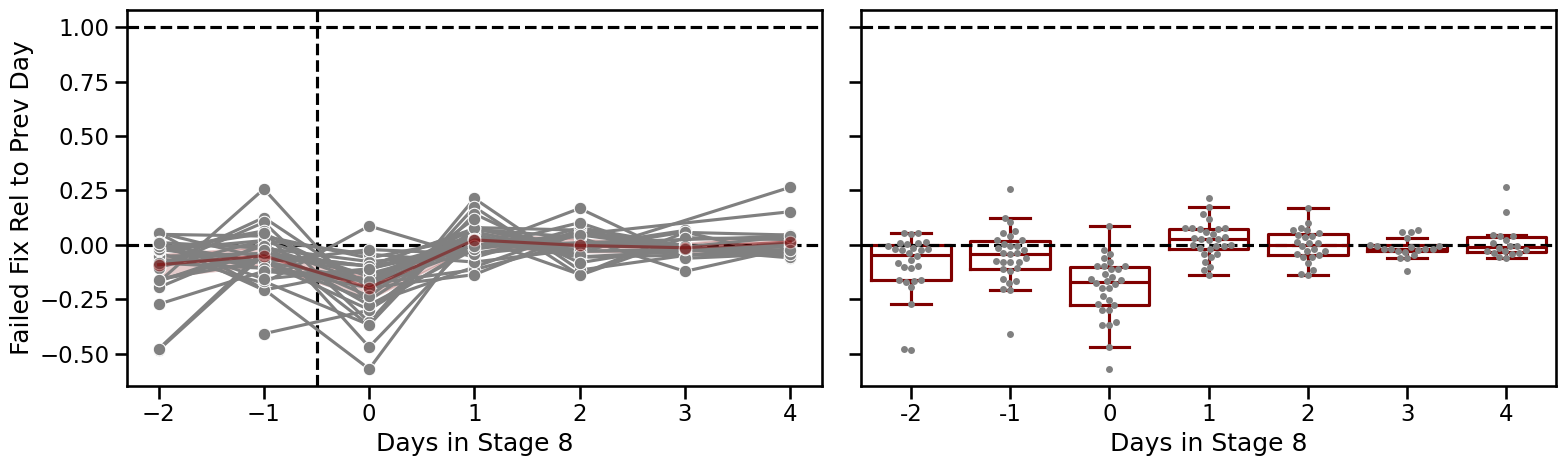

In [17]:
delta_df["failed_fixation_rate_relative_to_yesterday"] = delta_df.groupby(
    "animal_id"
).failed_fixation_rate.diff()

plot_metric_over_stage_8(
    delta_df,
    y_var="failed_fixation_rate_relative_to_yesterday",
    set_kwargs={"ylabel": "Failed Fix Rel to Prev Day"},
)

Again this plot supports violation rate having the most change on the first day of violation penalty and then it appears to stay mostly stable throughout.

### 2.2 Days to Lowest Violation Rate

We will start by looking at all the days in stage 8

[Text(0.5, 1.0, 'Median: 1.0, Mean: 2.23')]

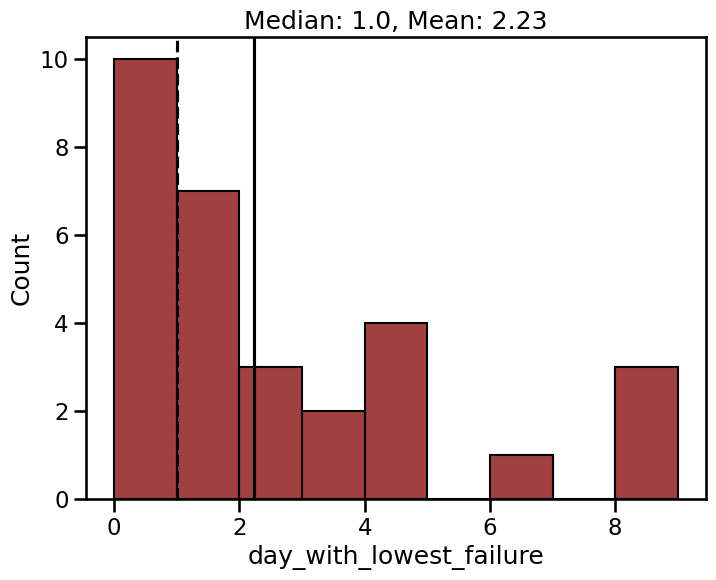

In [18]:
plot_df = delta_df.query(
    "stage < 9 and days_relative_to_8 > -1 and days_relative_to_8 < 10"
)

min_days = (
    plot_df.loc[plot_df.groupby("animal_id")["failed_fixation_rate"].idxmin()]
    .reset_index(drop=True)
    .rename(columns={"days_relative_to_8": "day_with_lowest_failure"})[
        ["animal_id", "day_with_lowest_failure"]
    ]
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=min_days, x="day_with_lowest_failure", color="maroon", binwidth=1)

median = min_days["day_with_lowest_failure"].median()
mean = min_days["day_with_lowest_failure"].mean()

ax.axvline(median, color="black", linestyle="--")
ax.axvline(mean, color="black", linestyle="-")

ax.set(
    title=f"Median: {median}, Mean: {mean:.2f}",
)

Now lets force it to be 5 days or less

[Text(0.5, 1.0, 'Median: 1.0, Mean: 1.50')]

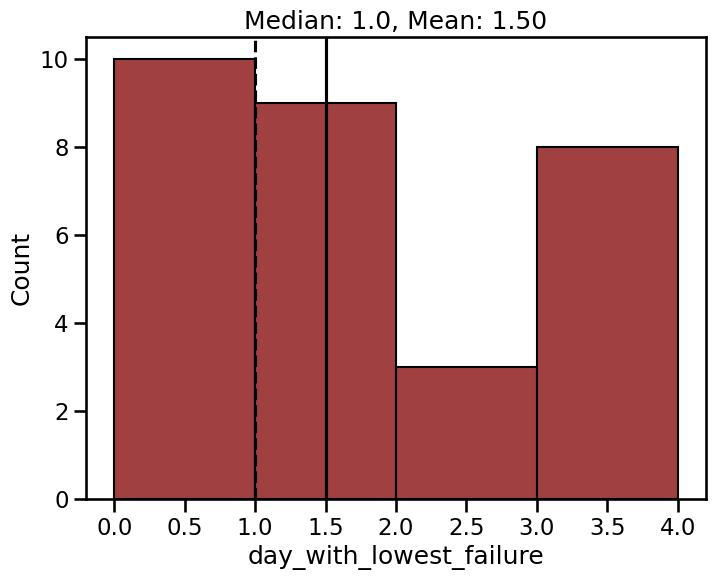

In [19]:
plot_df = delta_df.query(
    "stage < 9 and days_relative_to_8 > -1 and days_relative_to_8 < 6"  # 5 days
)

min_days = (
    plot_df.loc[plot_df.groupby("animal_id")["failed_fixation_rate"].idxmin()]
    .reset_index(drop=True)
    .rename(columns={"days_relative_to_8": "day_with_lowest_failure"})[
        ["animal_id", "day_with_lowest_failure"]
    ]
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=min_days, x="day_with_lowest_failure", color="maroon", binwidth=1)

median = min_days["day_with_lowest_failure"].median()
mean = min_days["day_with_lowest_failure"].mean()

ax.axvline(median, color="black", linestyle="--")
ax.axvline(mean, color="black", linestyle="-")

ax.set(
    title=f"Median: {median}, Mean: {mean:.2f}",
)

### 2.3 Rolling window of Violation Rate 

In [20]:
sub_df = df.query("days_relative_to_8 >= -2 and days_relative_to_8 < 6").copy()

sub_df["cumulative_trial_8"] = (
    sub_df.sort_values(by=["days_relative_to_8"]).groupby("animal_id")["trial"].cumsum()
)

In [21]:
window_size = 30
sub_df = (
    sub_df.groupby(["animal_id", "days_relative_to_8"])
    .apply(
        rolling_avg,
        window_size=window_size,
    )
    .reset_index(drop=True)
)

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_29102/2363203586.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_df.groupby(["animal_id", "days_relative_to_8"])


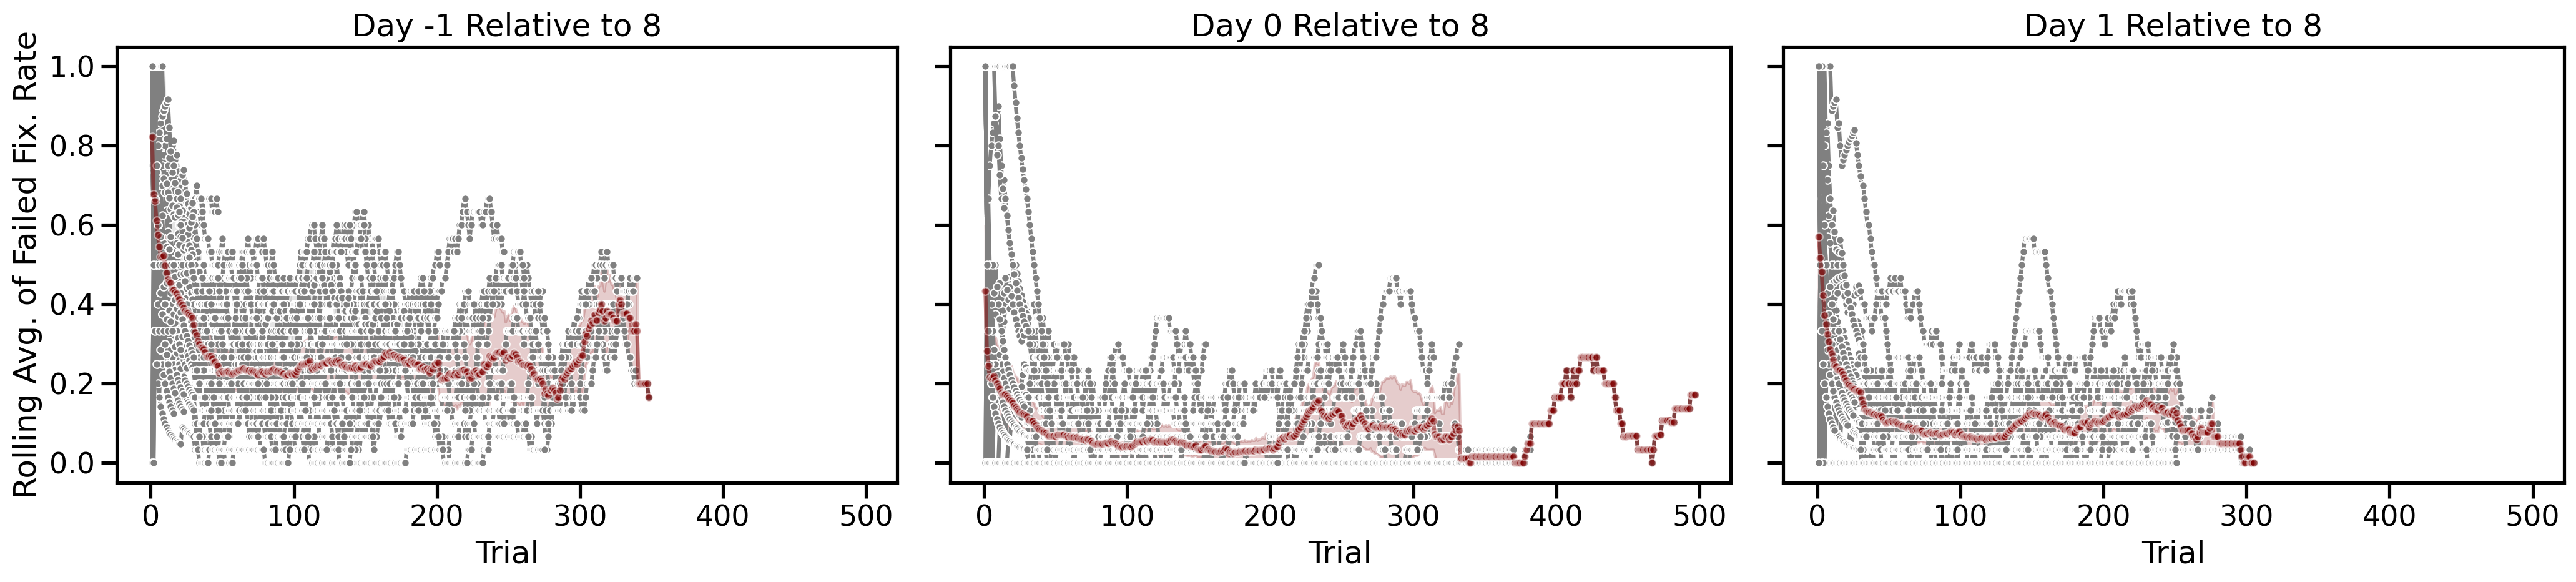

In [22]:
plot_rolling_averages(sub_df, window_size, days_range=(-1, 0, 1))

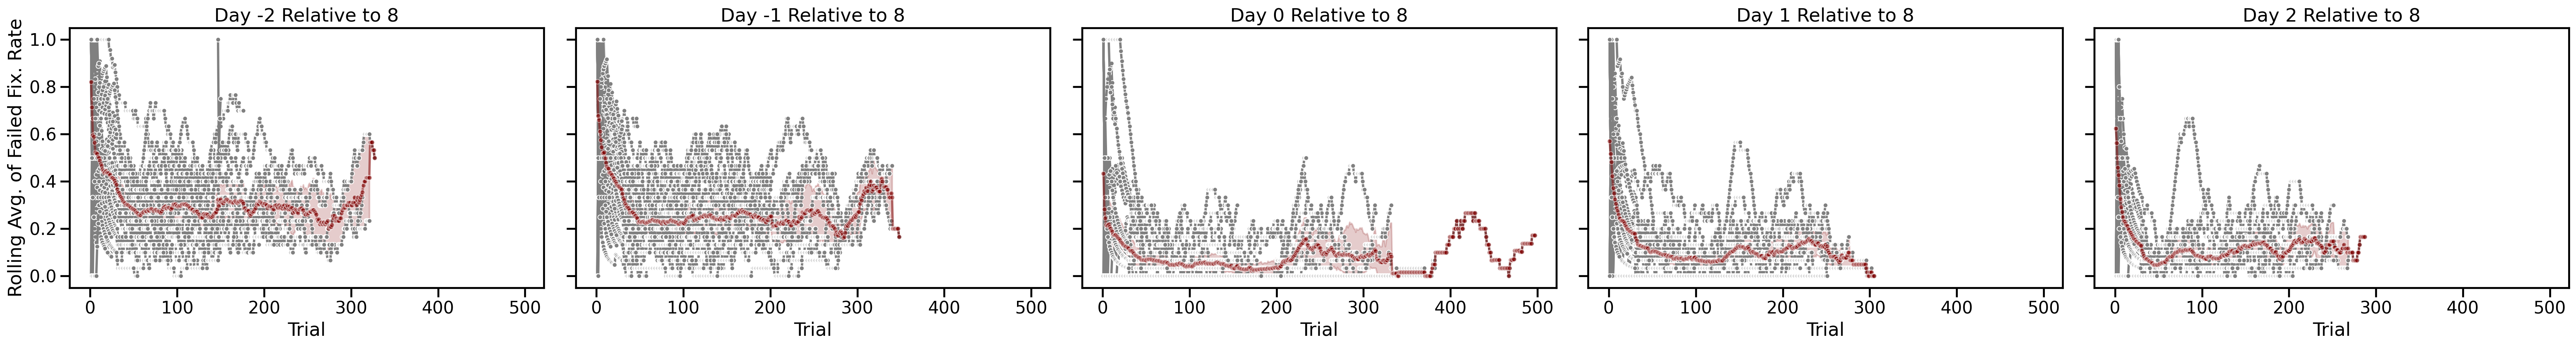

In [23]:
plot_rolling_averages(sub_df, window_size, days_range=(-2, -1, 0, 1, 2))

### 2.4 Normalized Violation Rate

In [24]:
viol_df.head()

,animal_id,days_relative_to_8,failed_fixation_rate,penalty_type,stage
0,C215,-18,0.600000,none,5.0
1,C215,-17,0.571429,none,5.0
2,C215,-16,0.181818,none,5.0
3,C215,-8,0.292929,none,5.0
4,C215,-7,0.467105,none,5.0


In [25]:
# Step 1: Set the baseline
# Find the failed_fixation_rate on days_relative_to_8 == -1 for each animal
baseline_rates = viol_df[viol_df["days_relative_to_8"] == -1].set_index("animal_id")[
    "failed_fixation_rate"
]

day_8_max = 6
lowest_failure_rates = (
    viol_df.query("days_relative_to_8 < @day_8_max")
    .groupby("animal_id")["failed_fixation_rate"]
    .min()
)

relative_df = viol_df.join(baseline_rates, on="animal_id", rsuffix="_baseline")
relative_df = relative_df.join(lowest_failure_rates, on="animal_id", rsuffix="_lowest")

relative_df["normalized_failed_fixation_rate"] = (
    relative_df["failed_fixation_rate"] - relative_df["failed_fixation_rate_baseline"]
) / (
    relative_df["failed_fixation_rate_lowest"]
    - relative_df["failed_fixation_rate_baseline"]
)

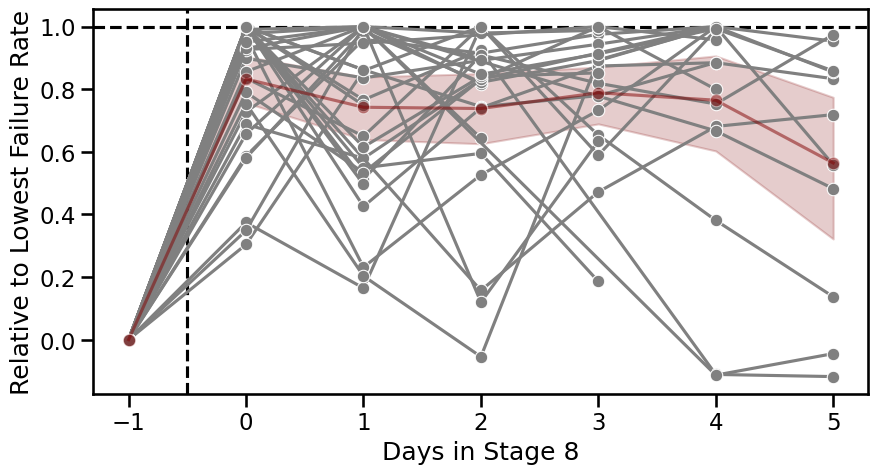

In [26]:
plot_df = relative_df.query(
    "stage < 9 and days_relative_to_8 > -2 and days_relative_to_8 < @day_8_max"
)
y_var = "normalized_failed_fixation_rate"

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    marker="o",
    palette=sns.color_palette(["gray"], n_colors=plot_df.animal_id.nunique()),
    hue="animal_id",
    ax=ax,
    errorbar=None,
    zorder=100,
)

sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    marker="o",
    color="maroon",
    alpha=0.5,
    ax=ax,
    zorder=100,
)

_ = ax.set(
    xlabel="Days in Stage 8",
    ylabel="Relative to Lowest Failure Rate",
)

ax.get_legend().remove()
ax.axvline(-0.5, color="black", linestyle="--")
ax.axhline(1, color="black", linestyle="--")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 62.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 55.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


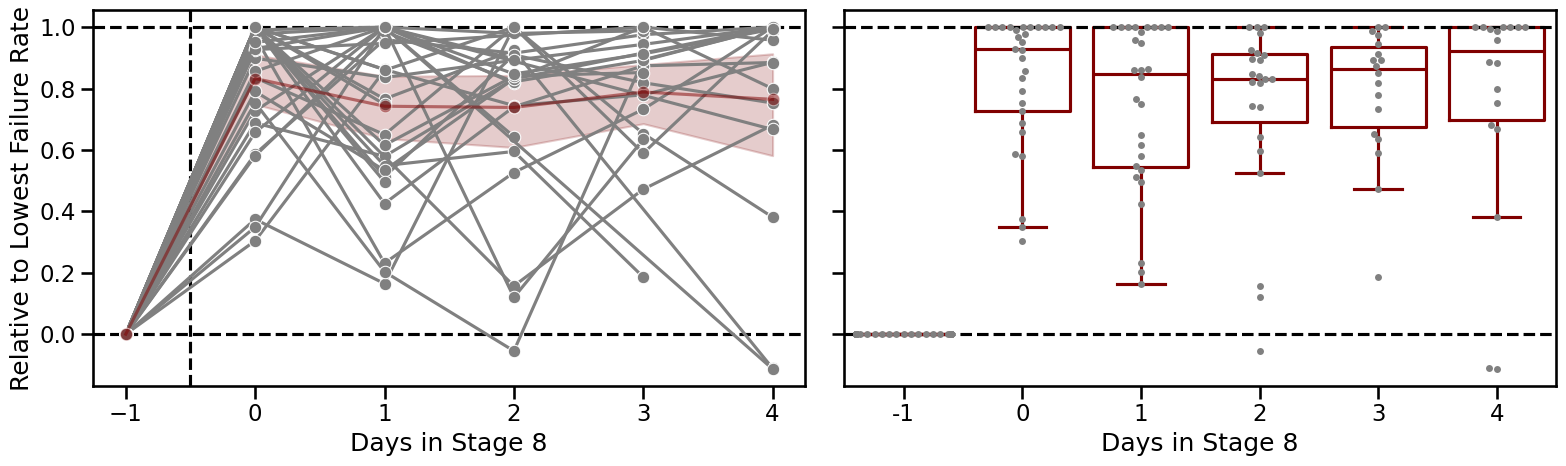

In [27]:
plot_metric_over_stage_8(
    plot_df,
    y_var="normalized_failed_fixation_rate",
    set_kwargs={"ylabel": "Relative to Lowest Failure Rate"},
)

Text(0.5, 0, 'Days')

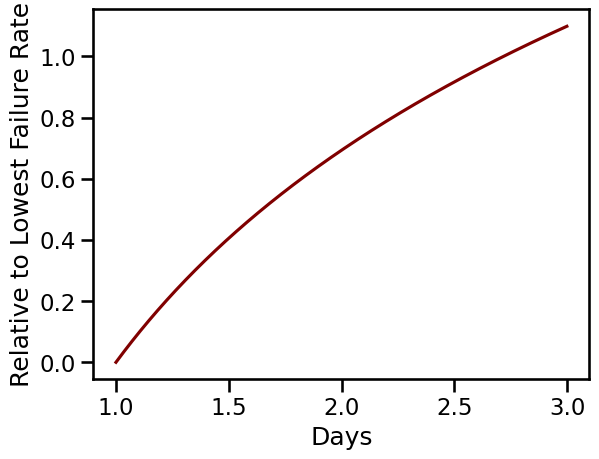

In [28]:
x = np.arange(1, 3, 0.001)
y = np.log(x)

plt.plot(x, y, color="maroon")
plt.ylabel("Relative to Lowest Failure Rate")
plt.xlabel("Days")

## 3. Relative Hit Rates

Now lets see if there is any change in the hit rate over days. We will repeat the same analyses as above with violation rates.

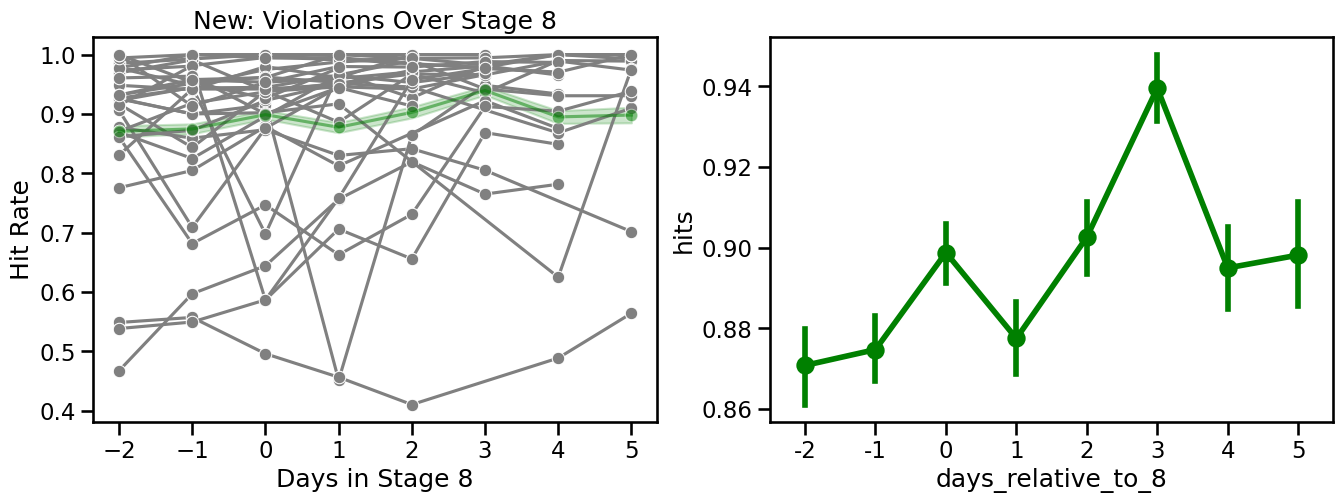

In [29]:
y_var = "hits"
plot_df = df.query("stage < 9 and days_relative_to_8 > -3 and days_relative_to_8 < 6")

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    marker="o",
    palette=sns.color_palette(["gray"], n_colors=plot_df.animal_id.nunique()),
    hue="animal_id",
    ax=ax[0],
    errorbar=None,
    zorder=100,
)

sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    marker="o",
    color="green",
    alpha=0.5,
    ax=ax[0],
    zorder=100,
)

sns.pointplot(
    data=plot_df,
    x="days_relative_to_8",
    y=y_var,
    color="green",
    ax=ax[1],
)

_ = ax[0].set(
    xlabel="Days in Stage 8",
    ylabel="Hit Rate",
    title="New: Violations Over Stage 8",
)

ax[0].get_legend().remove()

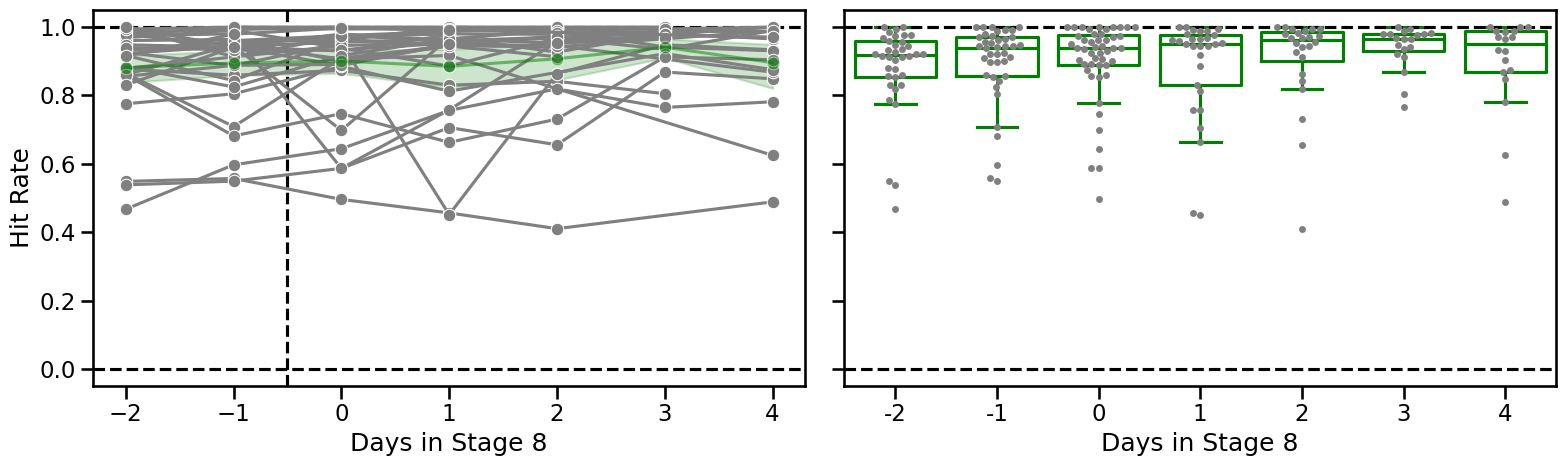

In [39]:
hit_df = (
    df.groupby(["animal_id", "days_relative_to_8", "stage"])["hits"]
    .mean()
    .reset_index()
)
plot_metric_over_stage_8(
    hit_df,
    y_var="hits",
    set_kwargs={"ylabel": "Hit Rate"},
    color="green",
)

### 3.1 Hit Rates Relative to Previous Day

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


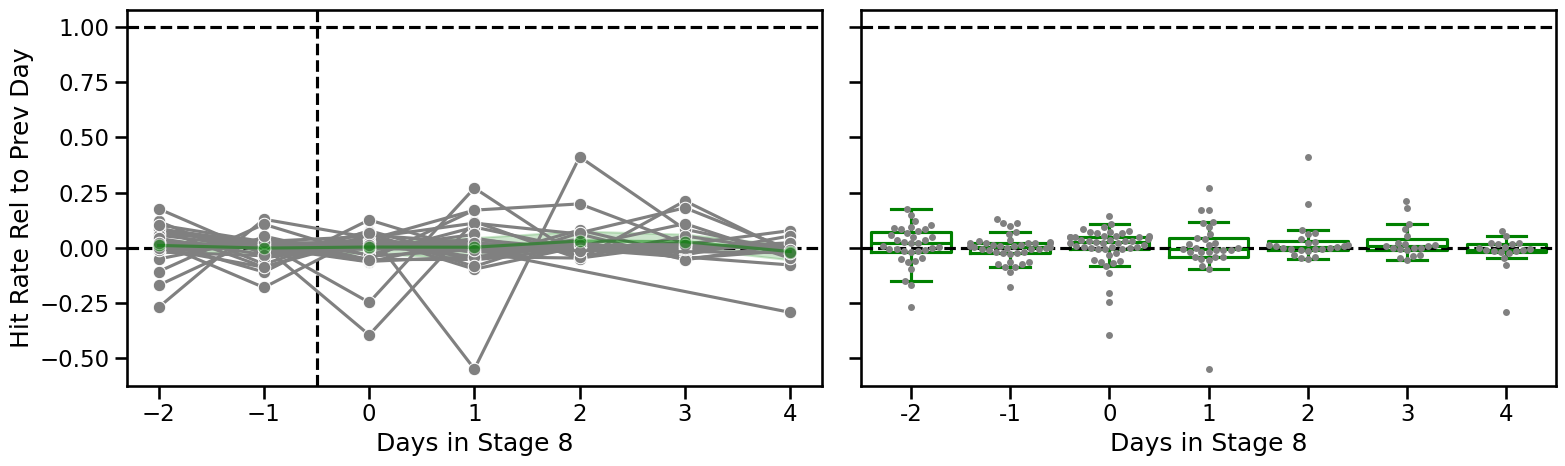

In [37]:
hit_df["hits_relative_to_yesterday"] = hit_df.groupby("animal_id")["hits"].diff()

plot_metric_over_stage_8(
    hit_df,
    y_var="hits_relative_to_yesterday",
    set_kwargs={"ylabel": "Hit Rate Rel to Prev Day"},
    color="green",
)

## 4. Relative Trials

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


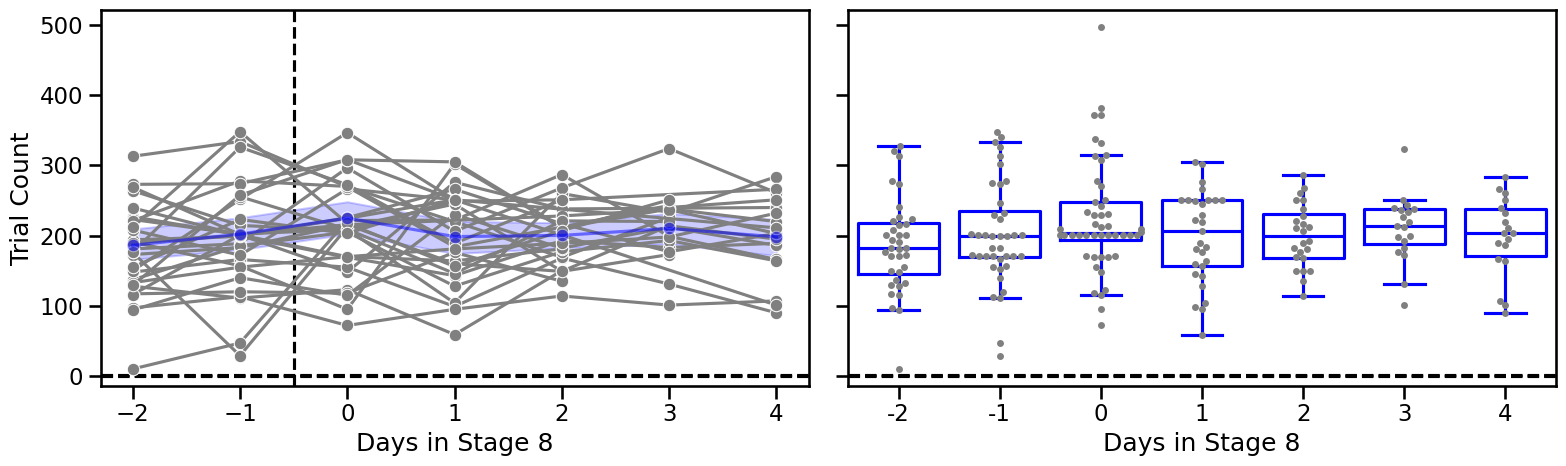

In [41]:
trial_df = (
    df.groupby(["animal_id", "days_relative_to_8", "stage"])["trial"]
    .max()
    .reset_index()
)

plot_metric_over_stage_8(
    trial_df,
    y_var="trial",
    set_kwargs={"ylabel": "Trial Count"},
    color="blue",
)

### 4.1 Trials Relative to Previous Day

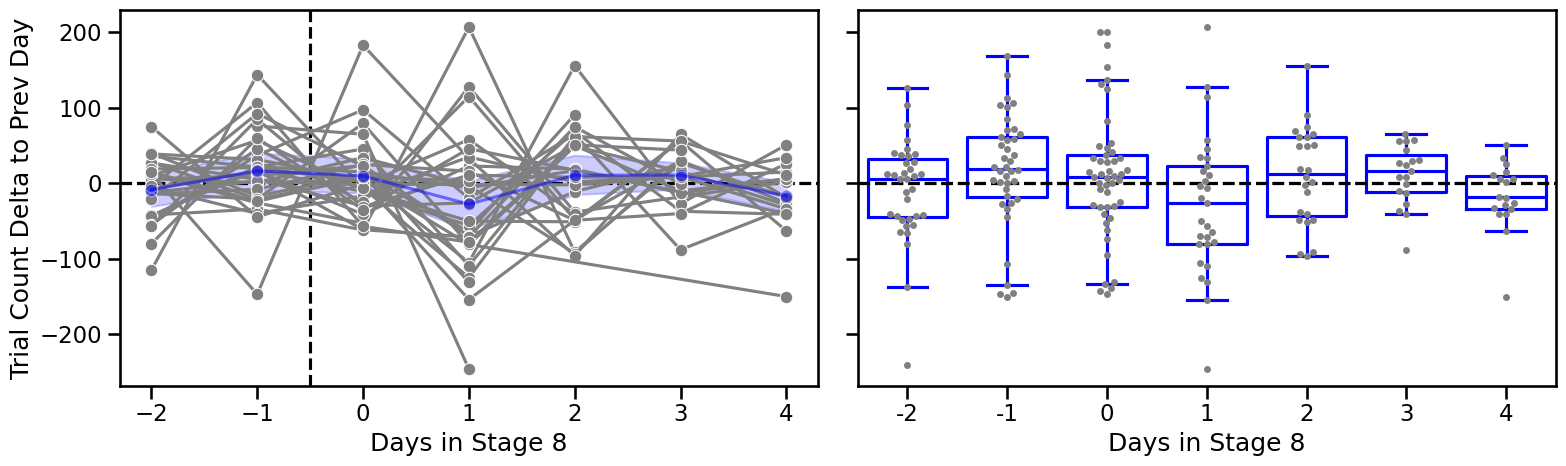

In [45]:
trial_df["trial_relative_to_yesterday"] = trial_df.groupby("animal_id")["trial"].diff()

plot_metric_over_stage_8(
    trial_df,
    y_var="trial_relative_to_yesterday",
    set_kwargs={"ylabel": "Trial Count Delta to Prev Day"},
    color="blue",
)